# Counterfactual Transportability

This notebook is a demonstration of algorithms from Correa, Lee, and Bareinboim's 2022 paper, [Counterfactual Transportability: A Formal Approach](https://proceedings.mlr.press/v162/correa22a/correa22a.pdf).

In [2]:
import logging

from y0.algorithm.counterfactual_transportability import (
    transport_conditional_counterfactual_query,
    transport_unconditional_counterfactual_query,
)
from y0.algorithm.transport import transport_variable
from y0.dsl import (
    PP,
    TARGET_DOMAIN,
    X1,
    R,
    P,
    Pi1,
    Pi2,
    W,
    X,
    Y,
    Z,
    Variable,
)
from y0.graph import NxMixedGraph
from y0.algorithm.identify import identify_outcomes

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# logger.setLevel(logging.INFO) # Uncomment to view some of the function calls happening under the hood

## Motivating example

Suppose in a study of vaccine efficacy we're interested in the effect of COVID vaccination on the number of days that a person who gets COVID reports Infected. We might imagine a graph like the following:



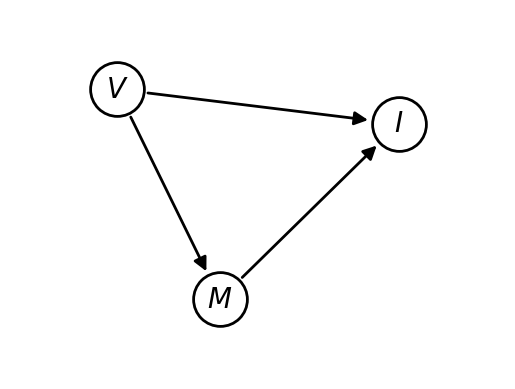

In [4]:
# Declare some variables first

Vaccinated = Variable("V")
Masked = Variable("M")
Infected = Variable("I")

simple_covid_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Masked),
        (Masked, Infected),
        (Vaccinated, Infected),
    ],
    undirected=[],
)
simple_covid_graph.draw()

For purposes of simplicy, $V$ represents whether a vaccine was administered or not, $M$ represents whether a mask was worn during the two weeks prior to a COVID infection, and $I$ represents whether the person tested positive for COVID-19. The vaccine efficacy affects the likelihood of infection, but vaccination can also affect masking behavior by increasing a person's risk tolerance, and masking may affect a person's likelihood of COVID by adjusting the amount of initial viral load to which they were exposed. Thanks to an implementation of Shpitser's ID algorithm in $Y_0$, we can estimate the total effect of the vaccine on symptom duration:

In [5]:
identify_outcomes(simple_covid_graph, treatments={Vaccinated}, outcomes={Infected})

Sum[M](P(I | M, V) * P(M | V))

This model is of course too simplistic, because many unmeasured factors affect both the vaccine type and masking preferences such as medical history, social network effects, and so on. Let's represent those unmeasured factors, "confounders", by a bi-directed edge between Vaccinated and Masked:

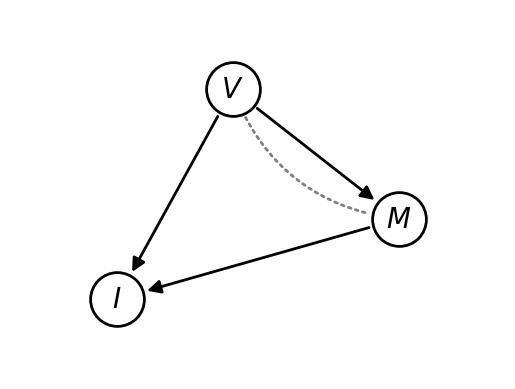

In [6]:
covid_with_confounders_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Masked),
        (Masked, Infected),
        (Vaccinated, Infected),
    ],
    undirected=[(Masked, Vaccinated)],
)
covid_with_confounders_graph.draw()

The effect of vaccination type on symptom duration is not identifiable due to the confounders:

In [7]:
identify_outcomes(
    covid_with_confounders_graph, treatments={Vaccinated}, outcomes={Infected}
) is None

True

The good news is that often we can determine a causal effect when a model is not identifiable by using experimental data from another setting, or by conditioning on additional variables. Let's see two examples in action!

## Conditional transportability example: vaccination and symptom duration

Suppose a person was vaccinated $V=v$, and was not infected $I=i$, and we want to know the likelihood that they would be infected had they not been vaccinated  $I_{do(V = v^\ast)}$. That would be represented in $Y_0$ as follows:

In [8]:
effect_of_vaccination_on_the_uninfected_vaccinated = P(
    Infected @ +Vaccinated | +Infected, -Vaccinated
)
display(effect_of_vaccination_on_the_uninfected_vaccinated)

P(I @ +V | +I, -V)

Next, let's consider that we have two populations: an observational study in the United States, and a vaccine efficacy study in Australia in which people were randomly assigned to receive vaccine or placebo, and the effect on symptom duration was observed. Moreover, suppose the distribution of people who wear masks in Australia is different than in the United States for unknown reasons.

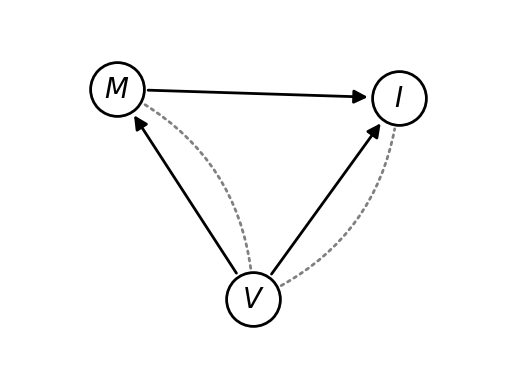

In [9]:
# This graph represents the target domain, the United States.
USA = Variable("USA")
observational_study_in_usa_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Masked),
        (Masked, Infected),
        (Vaccinated, Infected),
    ],
    undirected=[(Vaccinated, Masked), (Vaccinated, Infected)],
)
observational_study_in_usa_graph.draw()

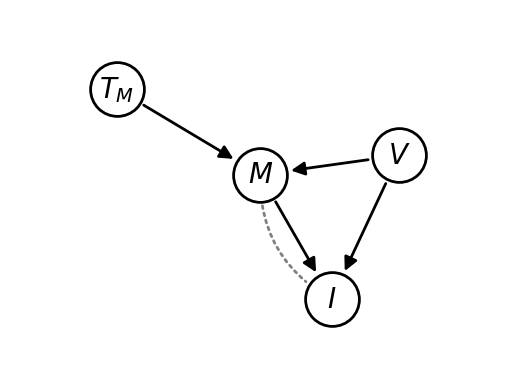

In [10]:
# Here is Australia.
Australia = Variable("AUS")
vaccine_efficacy_in_australia_graph = NxMixedGraph.from_edges(
    directed=[
        (Vaccinated, Masked),
        (Vaccinated, Infected),
        (Masked, Infected),
        (transport_variable(Masked), Masked),
    ],
    undirected=[(Masked, Infected)],
)
vaccine_efficacy_in_australia_graph.draw()

The transportability node in the graph is there to remind us that the difference in the mask wearing populations prohibits us from directly running the Identify algorithm on the graph for the Australian population to estimate the effect of vaccine type on symptom duration for the American sample.

We can estimate the effect using the conditional counterfactual transportability algorithm in `Y0`:

In [11]:
vaccine_efficacy_in_usa_query = [(Infected @ +Vaccinated, -Infected)]
unvaccinated_cohort = [(Vaccinated, -Vaccinated)]
domain_graphs = [
    (
        vaccine_efficacy_in_australia_graph,
        list(vaccine_efficacy_in_australia_graph.topological_sort()),
    ),
    (observational_study_in_usa_graph, list(observational_study_in_usa_graph.topological_sort())),
]

domain_data = [
    ({Vaccinated}, PP[Australia](Vaccinated, Infected, Masked)),
    (set(), PP[USA](Vaccinated, Infected, Masked)),
]

result_expr, result_event = transport_conditional_counterfactual_query(
    outcomes=vaccine_efficacy_in_usa_query,
    conditions=unvaccinated_cohort,
    target_domain_graph=observational_study_in_usa_graph,
    domain_graphs=domain_graphs,
    domain_data=domain_data,
)
print(str(result_event))
display(result_expr)

[(I, -I), (V, -V)]


((Sum[M](P(I | M, V) * P(M | V) * P(V)) / Sum[I, M](P(I | M, V) * P(M | V) * P(V))))

For this example, it turns out that we can just compute the probability of symptom duration given vaccine type and masking preference for the United States, and we don't actually need the Australian data. That can happen. Note that Correa, Lee, and Bareinboim have an algorithm for _conditional transportability_ and an algorithm for _unconditional transportability_. Suppose we are interested in the probability that a person would get infected if they were unvacinated and they would not get infected if they were vaccinated

In [12]:
event = [(Infected @ -Vaccinated, +Infected), (Infected @ +Vaccinated, -Infected)]
transport_unconditional_counterfactual_query(
    event=event,
    target_domain_graph=observational_study_in_usa_graph,
    domain_graphs=domain_graphs,
    domain_data=domain_data,
) is None

True

It turns out that there are not enough constraints provided by the assumptions of the model and the domain data to identify an answer the question.  

## Unconditional transportability example: anti-retroviral therapy (ART) and AIDS mortality

Suppose we're interested in the effect of HIV anti-retroviral therapy ($T$) on mortality from AIDS ($A$) in Nigeria, in a model where the distance to the nearest clinic ($D$) affects mortality and selection into the type of ART regimen, while also being confounded with the ART treatment (e.g., personal income could affect the affordability of ARTs and the mode of transportation a person uses to access the clinic). Additionally, the ART treatment affects a person's CD4 count ($C$), which affects mortality from AIDS and is also confounded with mortality, as comorbidity with other diseases could affect both the CD4 count and AIDS-related mortality. Here's the graph:

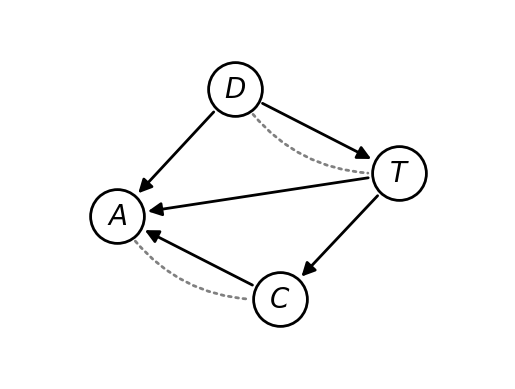

In [13]:
# Declare variables
Therapy = Variable("T")
Distance = Variable("D")
CD4 = Variable("C")
AIDS = Variable("A")
nigeria_population = Variable(r"\pi_{Nigeria}")
nigeria_graph = NxMixedGraph.from_edges(
    directed=[
        (Distance, Therapy),
        (Distance, AIDS),
        (Therapy, AIDS),
        (Therapy, CD4),
        (CD4, AIDS),
    ],
    undirected=[(Distance, Therapy), (CD4, AIDS)],
)
nigeria_topo = list(nigeria_graph.topological_sort())
nigeria_graph.draw()

Earlier in the AIDS epidemic, rumors existed in some parts of Africa that ARTs and not the HIV virus were responsible for causing AIDS, and that raised concerns at the time that some people may not take ARTs even were they made available. Assuming that a program to provide ARTs to the public would only work if people are willing to take the drugs, suppose we want to know what receiving ARTs ($t_0$) does to AIDS-related mortality in a target population $\pi^\ast$, but specifically for people who choose to receive generic ARTs. So, we care about the difference in mortality for a person who chooses to take ARTs, compared to those for a person required to take them. Thus, we wish to know $E[A_{t_0} | t_0] - E[A_t | t_0]$. The first quantity is $E[A | t_0] = E[A, t_0] / E[t_0]$, and the second is $E[A_t | t_0] = E[A_t, t_0] / E[t_0]$. Let's estimate $E[A_t, t_0]$ using `transport_unconditional_counterfactual_query()`, introducing our data sets first.

### Data

Here we imagine we have a study in a different country (Ghana) than the target country (Nigeria) in which ARTs were delivered to participants' villages directly, removing the bi-directed edge between $D$ and $T$. But the study population, $\pi^{Ghana}$, has a different distribution of distance to the nearest clinic than our population of interest $\pi^{Nigeria}$:


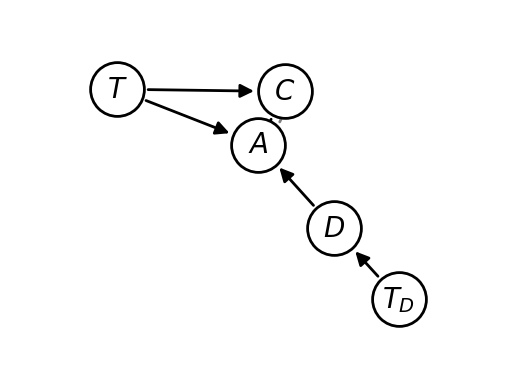

In [14]:
ghana_population = Variable(r"\pi_{Ghana}")
ghana_with_delivery_graph = NxMixedGraph.from_edges(
    directed=[
        (Therapy, AIDS),
        (Therapy, CD4),
        (CD4, AIDS),
        (Distance, AIDS),
        (transport_variable(Distance), Distance),
    ],
    undirected=[
        (CD4, AIDS),
    ],
)
ghana_with_delivery_topo = list(ghana_with_delivery_graph.topological_sort())
ghana_with_delivery_graph.draw()

The second set of data is an observational study in a high-risk population of injecting drug users, $\pi^{Drug}$, for which the overall CD4 count distribution is also different than the target population $\pi^{Nigeria}$ but the distribution of distances to the nearest clinic is the same:

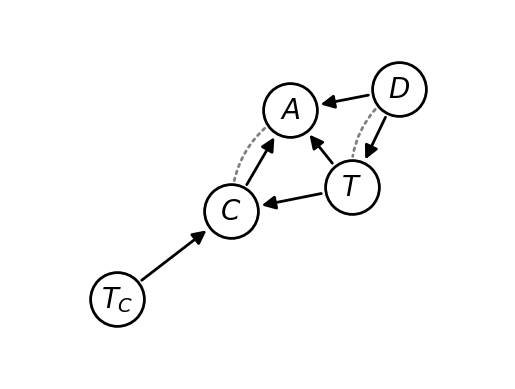

In [15]:
# From [correa22a]_, Figure 3b.
drug_user_population = Variable(r"\pi_{Drug}")
drug_user_graph = NxMixedGraph.from_edges(
    directed=[
        (Distance, Therapy),
        (Distance, AIDS),
        (Therapy, AIDS),
        (Therapy, CD4),
        (CD4, AIDS),
        (transport_variable(CD4), CD4),
    ],
    undirected=[(Distance, Therapy), (CD4, AIDS)],
)
drug_user_topo = list(drug_user_graph.topological_sort())
drug_user_graph.draw()

Let's estimate $E[A_t, t_0]$:

In [16]:
effect_of_do_art_on_aids_query = [(AIDS @ -Therapy, -AIDS), (Therapy, +Therapy)]
art_for_aids_domain_graphs = [
    # (
    #     nigeria_graph,
    #     nigeria_topo,
    # ),
    (
        ghana_with_delivery_graph,
        ghana_with_delivery_topo,
    ),
    (
        drug_user_graph,
        drug_user_topo,
    ),
]
art_for_aids_domain_data = [
    # (set(), PP[nigeria_population](CD4, Therapy, AIDS, Distance)),
    ({Therapy}, PP[ghana_population](CD4, Therapy, AIDS, Distance)),
    (set(), PP[drug_user_population](CD4, Therapy, AIDS, Distance)),
]

do_art_on_aids_expr, do_art_on_aids_event = transport_unconditional_counterfactual_query(
    event=effect_of_do_art_on_aids_query,
    target_domain_graph=nigeria_graph,
    domain_graphs=art_for_aids_domain_graphs,
    domain_data=art_for_aids_domain_data,
)

In [17]:
print(str(do_art_on_aids_event))
display(do_art_on_aids_expr)

[(A @ -T, -A), (T, +T)]


Sum[C, D](P(D) * P(T | D) * P(A | T, D, C) * P(C | T))

Here we can see the results from the two domain populations getting combined to resolve a causal query for the target population! That result matches Equation 4 in Correa, Lee, and Bareinboim net of some simplification. Next, here's $E[A, t0]$:

In [18]:
effect_of_see_art_on_aids_query = [(AIDS, -AIDS), (Therapy, +Therapy)]
see_art_for_aids_expr, see_art_for_aids_event = transport_unconditional_counterfactual_query(
    event=effect_of_see_art_on_aids_query,
    target_domain_graph=nigeria_graph,
    domain_graphs=art_for_aids_domain_graphs,
    domain_data=art_for_aids_domain_data,
)

In [19]:
print(str(see_art_for_aids_event))
display(see_art_for_aids_expr)

[(A, -A), (T, +T)]


Sum[C, D](P(D) * P(T | D) * P(A | T, D, C) * P(C | T))

Compare this result to Equation 5 in Correa, Lee, and Bareinboim. Combining these two results, we can estimate our causal effect of interest.

It's worth noting we can also use `transport_conditional_counterfactual_query()` to estimate $P(A_t | t_0)$. The result is messier, but simplifying it and multiplying by $P(t_0)$ gives us the unconditional query result:

In [20]:
do_art_see_no_art_expr, do_art_see_no_art_event = transport_conditional_counterfactual_query(
    outcomes=[(AIDS @ -Therapy, -AIDS)],
    conditions=[(Therapy, +Therapy)],
    target_domain_graph=nigeria_graph,
    domain_graphs=art_for_aids_domain_graphs,
    domain_data=art_for_aids_domain_data,
)

In [21]:
print(str(do_art_see_no_art_event))
display(do_art_see_no_art_expr)

[(A, -A), (T, +T)]


((Sum[C, D](P(D) * P(T | D) * P(A | T, D, C) * P(C | T)) / Sum[A, C, D](P(D) * P(T | D) * P(A | T, D, C) * P(C | T))))

## Climate change example: carbon taxes and cloud seeding

       Recent years have seen an increase in heat domes in North America and other extremes in hot and cold weather. One theory for their increase in frequency is that as the temperature of the earth rises and the polar ice caps melt the temperature differential between the poles and the equator drops, leading to a slowing-down of the jet stream that causes it to meander like a river does on a shallow grade compared to a steep slope. That in turn can create "heat domes" during the summer -- places where the jet stream deviates to the north, along with associated fires and droughts. It can also create copious amounts of snowfall and frigid winters elsewhere for the same reason. Let's consider a scenario in which the United States, concerned about heat domes and their effects on reservoir levels in the future, is considering imposing a carbon tax in order to both directly affect temperatures and also subsidize cities such as New York to conduct cloud seeding to keep reservoirs filled during emergencies. A graph might look like the following:

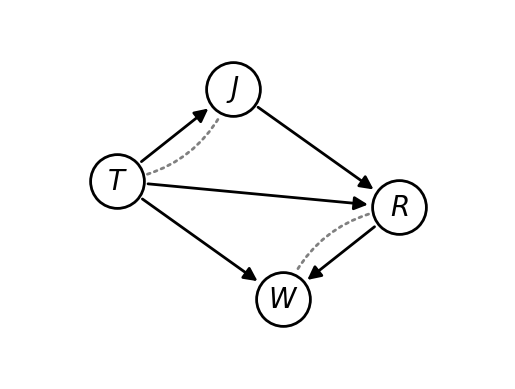

In [46]:
# Based on [correa20a]_, Figure 1.
USA_population = Variable(r"\pi_{USA}")
Temperature = Variable("T")
JetStream = Variable("J")
Rainfall = Variable("R")
WaterSupply = Variable("W")

USA_graph = NxMixedGraph.from_edges(
    directed=[
        (Temperature, JetStream),
        (Temperature, Rainfall),
        (JetStream, Rainfall),
        (Temperature, WaterSupply),
        (Rainfall, WaterSupply),
    ],
    undirected=[(Temperature, JetStream), (Rainfall, WaterSupply)],
)
USA_topo = list(USA_graph.topological_sort())
USA_domain_data = (set(), PP[USA_population](Temperature, JetStream, Rainfall, WaterSupply))
USA_graph.draw()

       In this graph, rising temperature affects the speed of the jet stream. It also indirectly increases precipitation by evaporating water on land and directly decreases reservoir volumes by evaporating reservoir water. Natural phenomena such as El Niño or the 18-year period of nutation of the planet on its axis may affect both temperature and the jet stream velocity, hence the bidirected edge between J and T. Rainfall of course directly affects reservoir volumes, and other factors such as land usage affect both precipitation and reservoir volumes. 

       Suppose that Washington DC is contemplating the effect of a carbon tax, which for the purpose of simplicity we represent as a policy directly affecting temperature. The tax will also pay for a program to seed clouds whenever the jet stream meanders north during the summer and creates heat domes over the water supplies of large urban centers. The policy would therefore look as follows:

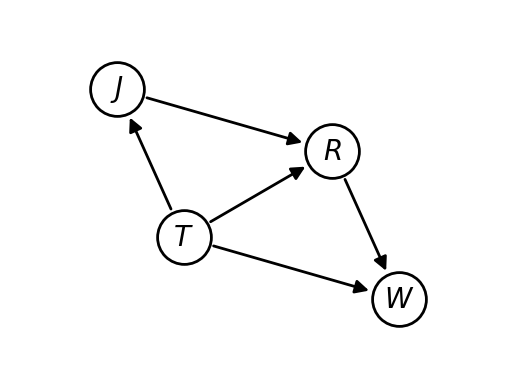

In [47]:
USA_population = Variable(r"\pi_{USA}")
USA_graph_under_policy = NxMixedGraph.from_edges(
    directed=[
        (Temperature, JetStream),
        (Temperature, Rainfall),
        (JetStream, Rainfall),
        (Temperature, WaterSupply),
        (Rainfall, WaterSupply),
    ],
    undirected=[],
)
USA_graph_under_policy_topo = list(USA_graph_under_policy.topological_sort())
USA_graph_under_policy.draw()

       To do its forecasting, the United States government only has observational data from the US. Suppose that China, however, has already conducted experiments with using a carbon tax to pay for cloud seeding -- except that the timing of cloud seeding was not a function of the jet stream velocity but rather the occurrence of holidays and other special events that can be assumed to be independent of fluctuations in the jet stream. Furthermore, cities in China are more densely populated than in the United States, so we represent a different baseline distribution of reservoir volumes with a transportability node:

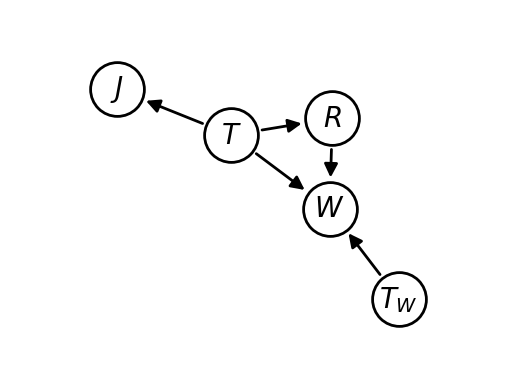

In [53]:
China_population = Variable(r"\pi_{China}")
China_graph = NxMixedGraph.from_edges(
    directed=[
        (Temperature, JetStream),
        (Temperature, Rainfall),
        (Temperature, ReservoirVolume),
        (Rainfall, ReservoirVolume),
        (transport_variable(WaterSupply), WaterSupply)
    ],
    undirected=[],
)
China_domain_data = ({Temperature, Rainfall}, PP[China_population](Temperature, JetStream, Rainfall, WaterSupply))
China_topo = list(China_graph.topological_sort())
China_graph.draw()



       Finally, we have data from a cloud seeding experiment in South Africa in which clouds were seeded whenever cities experienced heat domes, but which did not involve the imposition of a carbon tax. South Africa is in the Southern Hemisphere, so the jet stream will move differently than in the case of the United States and China and we attach a transportability node to the `JetStream` variable. Additionally, the absence of a carbon tax implies no intervention in the temperatures, so the bidirectional edge between `Temperature` and `JetStream` remains. 

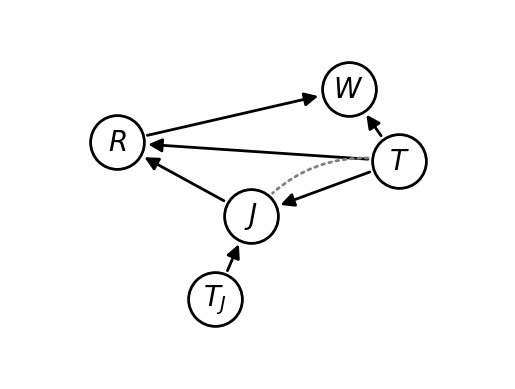

In [54]:
South_Africa_population = Variable(r"\pi_{SA}")
South_Africa_graph = NxMixedGraph.from_edges(
    directed=[
        (Temperature, JetStream),
        (JetStream, Rainfall),
        (Temperature, Rainfall),
        (Temperature, ReservoirVolume),
        (Rainfall, ReservoirVolume),
        (transport_variable(JetStream), JetStream),
    ],
    undirected=[(Temperature, JetStream)],
)
South_Africa_topo = list(South_Africa_graph.topological_sort())
South_Africa_domain_data = ({Rainfall}, PP[South_Africa_population](Temperature, JetStream, Rainfall, WaterSupply))
South_Africa_graph.draw()

       Suppose the United States would like to know the amount of water that New York City would have had in its reservoirs this year were it to have implemented a carbon tax in 2019 and begun cloud seeding to compensate for the effects of heat domes. We frame an unconditional counterfactual query:

In [55]:
effect_of_do_tax_query = [(WaterSupply @ -Temperature, -WaterSupply)]

#effect_of_do_art_on_aids_query = [(AIDS @ -Therapy, -AIDS), (Therapy, +Therapy)]
do_tax_domain_graphs = [
    (
        USA_graph,
        USA_topo,
    ),
    (
        China_graph,
        China_topo,
    ),
    (
        South_Africa_graph,
        South_Africa_topo,
    ),
]
effect_of_do_tax_domain_data = [USA_domain_data, China_domain_data, South_Africa_domain_data]


do_tax_expr, do_tax_event = transport_unconditional_counterfactual_query(
    event=effect_of_do_tax_query,
    target_domain_graph=USA_graph_under_policy,
    domain_graphs=do_tax_domain_graphs,
    domain_data=effect_of_do_tax_domain_data,
)

In [56]:
display(do_tax_expr)

Sum[J, R](P(J | T) * P(W | T, J, R) * Sum[W](P(R | T, J)))

In [60]:
# I need to check this calculation by hand in any case, but I'm not sure I like the fact that we're summing over W here.
print(str(do_tax_expr))

Sum[J, R](P(J | T) * P(W | T, J, R) * Sum[W](P(R | T, J)))


In [59]:
display(do_tax_event)

[(W @ -T, -W)]

       We can see that the probability of the water supply having value `-W` in 2024, given the carbon tax adjusted the temperature to `-T` in 2019, is identifiable and is a composite of experimental results from China and South Africa and observational data from the United States. Note that without the data from China and South Africa, the query is not identifiable:

In [62]:
effect_of_do_tax_query = [(WaterSupply @ -Temperature, -WaterSupply)]

#effect_of_do_art_on_aids_query = [(AIDS @ -Therapy, -AIDS), (Therapy, +Therapy)]
do_tax_domain_graphs_US_only = [
    (
        USA_graph,
        USA_topo,
    ),
]
effect_of_do_tax_domain_data_US_only = [USA_domain_data]


do_tax_expr_US_only_query = transport_unconditional_counterfactual_query(
    event=effect_of_do_tax_query,
    target_domain_graph=USA_graph_under_policy,
    domain_graphs=do_tax_domain_graphs_US_only,
    domain_data=effect_of_do_tax_domain_data_US_only,
)
do_tax_expr_US_only_query is None

True

## User interface demonstration

The following exercise is from a tutorial at Pacific Northwest National Laboratory that demonstrates that detailed validation of user inputs makes using the software easy. We've deliberately included some typos in the problem solution and show the software catching them. Feel free to experiment with the input parameters and generate other errors!

1. Construct a graph with the following edges:
X1 -> Z,
R -> Z,
Z -> W,
W -> Y,
W <-> Z

2. Consider you have available observational data from the target domain, and an experiment from Domain 1 in which W is fixed to be only a function of Z (breaking the bidirected edge between W and Z), and R is drawn from a different population than in the target domain.

3. Estimate $P(Y_{X1},W_{R}|X1)$ with the values ${-Y,-W,-X}$ respectively.

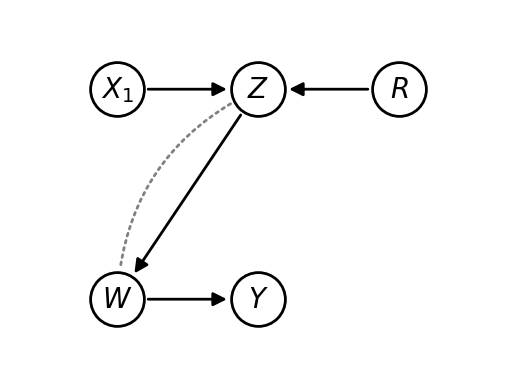

In [21]:
example_3_target_domain_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
    ],
    undirected=[(Z, W)],
)
example_3_target_domain_graph.draw()

In [22]:
example_3_break_w_graph = NxMixedGraph.from_edges(
    directed=[
        (X1, Z),
        (R, Z),
        (Z, W),
        (W, Y),
        (transport_variable(R), R),
    ],
    undirected=[],
)
# example_3_break_w_graph.draw()

In [23]:
example_3_outcomes = [(Y @ -X1, -Y), (W @ -R, -W)]
example_3_conditions = [(X, -X)]  ## NOTE: Should be X1

example_3_target_domain_graph_topo = list(example_3_target_domain_graph.topological_sort())
example_3_break_w_graph_topo = list(example_3_break_w_graph.topological_sort())
example_3_domain_graphs = [
    (
        example_3_break_w_graph,
        example_3_break_w_graph_topo,
    ),
    (
        example_3_target_domain_graph,
        [
            W,
            X1,
            R,
            Z,
            Y,
        ],  # example_3_target_domain_graph_topo,  ## NOTE: These vertices are not in an appropriate topological order
    ),
]
domain_data = [({W}, PP[Pi1](X1, R, W, Y, Z)), (set(), PP[TARGET_DOMAIN](X1, R, W, Y, Z))]
try:
    result_expr, result_event = transport_conditional_counterfactual_query(
        outcomes=example_3_outcomes,
        conditions=example_3_conditions,
        target_domain_graph=example_3_target_domain_graph,
        domain_graphs=example_3_domain_graphs,
        domain_data=domain_data,
    )
except ValueError as e:
    print(e)
print(str(result_event))
display(result_expr)

In _validate_transport_conditional_counterfactual_query_input: one of the input conditioned variables is not in the target domain graph. Check your inputs. 
[(I, -I), (V, -V)]


((Sum[M](P(I | V, M) * P(M | V) * P(V)) / Sum[I, M](P(I | V, M) * P(M | V) * P(V))))